In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper
%aimport training_models_helper

tmh = training_models_helper.TrainingModelsHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

In [4]:
from sklearn.model_selection import cross_val_score

# Interpreting the coefficients in Linear Models

The dot product has been a recurring character during our Classical Machine Learning journey.
$$
\Theta \cdot \x
$$

By examining this expression more closely
- We can gain insight into what $\Theta$ means
- Understand mathematically why transformation may be necessary
- Gain an appreciation of the "pattern matching" that it embodies

Recall the places in which dot product appears
- Linear Regression
$$
\hat{\y} = \Theta \cdot \x
$$

- Logistic Regression
$$
\hat{s} = \Theta \cdot \x
$$
for score $\hat{s}$ (which becomes a probability via $\hat{p} = \sigma(\hat{s})$

- Boundary equation for linearly separable classifiers, e.g., SVM
$$
0 = \Theta \cdot \x
$$


Consider one feature $\x^\ip_j$ for example $i$.

- A unit increase in $\x^\ip_j$
- Holding constant the values for all other features,
- Increases $\Theta \cdot \x^\ip$ by $\Theta_j$

Thus
$$
\Theta_j = \frac{\partial } {\partial \x_j} \Theta \cdot \x
$$

$\Theta_j$ may be interpreted as
- The sensitivity of $\Theta \cdot \x$ to changes in feature $j$

 ## Numeric features
 
Consider numeric features $\x_j, \x_{j'}$.

Does
$$
\Theta_j \gt \Theta_{j'}
$$
mean that feature $j$ is "more important" than feature $j'$ ?
- No !
- It just means it has a larger impact
- Which can *also* occur if $\x_j, \x_{j'}$ are on different scales

For example consider the equality
$$
\y = \Theta \cdot \x
$$

- Replacing  $\x_j$ 
- By $\x_{j''} = \x_j * 10$
- Mathematically results in $\Theta_{j''} = \Theta_j/10$

Thus, the scale of the parameter is dependent on the scale of the feature.

Unless two features are on the same scale: we can't directly compare their corresponding parameters.

## Categorical features

Consider a categorical feature with categories from
 $$C = \{ c_1, c_2, \ldots \}$$

One Hot Encoding this feature replaces the original feature with $||C||$ binary features

- $\text{Is}_{c_1}$
- $\text{Is}_{c_2}$
- $\vdots$
- $\text{Is}_{c_{||C||}}$
   


Suppose $\x_j$ corresponds to the binary feature
$$\text{Is}_{c_1}$$

Then, by the formula for dot product
- $\Theta_j$ is the *increment* to $\Theta \cdot \x$ 
- Arising from $\x^\ip_j = 1$
- Compared to $\x^\ip_j = 0$

That is: 
- $\Theta_j$ is how much $\Theta \cdot \x$ increases
- When example $i$ has feature value $c_1$ rather than any of $\{ c_2, \ldots, \}$

We can use this interpretation 
- To further emphasize the problem of
- Treating a categorical variables as a number rather than a collection of binary indicator variables

For example, let's revisit the Passenger Class `Pclass` $ \in \{1,2,3\}$ from the Titanic example.

- As a collection of binary indicator variables, the increment of being in each class is
$$
\Theta_{\text{Is}_1}, \Theta_{\text{Is}_2}, \Theta_{\text{Is}_3}
$$
- As a numeric variable with parameter value $\Theta_j$
    - Being in Class 3 has three times the effect as being in Class 1

Thus
- As numeric, we imply a particular magnitude with each category
- As binary indicator,the magnitude is determined by the data
      

# Motivating a transformation

Understanding the meaning of $\Theta$ may help us choose a transformation.

Suppose we have examples $\langle \X, \y \rangle$ where
$$
\y = \Theta \cdot \x
$$
**does not** seem to hold.

Perhaps a transformation to either/both of $\x, \y$ **will** make the relationship linear.


For example, consider
- $\y$ and $\x$ are time-series of prices, with different scales
- We observe that the impact on $\y$ of a *unit change* in $\x_j$
    - Is much bigger when $\x_j$ is small
    - Compared to when $\x_j$ is large
- So
    $$\y \ne \Theta \cdot \x$$ 

Now suppose we re-dominate (by transforming) the timeseries $\y$ and $\x$ to
- Timeseries $\y' = \text{daily % change in } \y$
- Timeseries $\x' = \text{daily % change in } \x$

This transformation from Price to Return is common in Finance.


It may now turn out that 
- A unit change in $\x'$
- Results in a change in $\y'$
- That is *independent* of the magnitude of $\x'$
- So
$$
\y' = \Theta' \cdot \x'
$$

That is
- A $1$ percentage point change in the price of $\x$
- Causes $\y$ to change by $\Theta'$ percentage points

So there **was** a relationship between $\y$ and $\x$, not in Price but in Return.

The Capital Asset Pricing Model of Finance postulates such a relationship and it is common to
transform prices to returns.

## Transformed targets

At times we may apply transformations to target values rather than just features.

This means that $\Theta_j$ is the sensitivity of the *transformed* target.


Recall that Logistic Regression could be formulated
as
- Linear Regression of the features
- Versus the *log odds*

$$
\log_e{\frac{\hat{p}}{1 - \hat{p}}} = \Theta^T \x
$$




So a unit change in feature $\x_j$ with parameter $\Theta_j$
changes the *odds* $\frac{\hat{p}}{1 - \hat{p}}$ in a *multiplicative* way

$$
\begin{array} \\
\Theta^T (\x+1) - \Theta^T \x & = & \Theta^T & \text{unit change in } \x \\
\log_e{\frac{\hat{p}}{1 - \hat{p}}} & &  &\text{increases to } \\
\log(\frac{\hat{p}}{1 - \hat{p}}) + \Theta_j \\
& = & \log{(\frac{\hat{p}}{1 - \hat{p}} * \exp{\Theta_j} ) } & \text{odds increase by factor of } \exp{\Theta_j}
\end{array}
$$
-

# Examples
- Log transform of target: 
    - $\log{\y} =   \Theta_0 + \Theta_1 * \x_1  $
    - $\theta_1 = { \partial{ \log{\y} } \over { \partial{ \x_1 } } } = \% $ change in $\y$ per unit change in $\x_1$
- Log transform of both target and feature:
    - $ \log{\y} =  \Theta_0 + \Theta_1 * \log{\x_1} $   
    - $\Theta_1 = { \partial{ \log{\y} } \over { \partial{ \log{\x_1} } } } = \% $ change in $\y$ per $\%$ change in $\x_1$
    
- Standardize feature
    - Transform $\x$ into $z_\x = { { \x - \bar{\x} } \over { \sigma_\x } }$
    - $\y = \Theta_0 + \Theta_1 * z_\x$
    - $\Theta_1 = { \partial{ \log{\y} } \over { \partial{ z_\x } } }$ change in $\y$ per $1$ standard deviation change in $\x$
        - since $z$ is in units of "number of standard deviations"
    

**Remember**
- if you transform features in training, you must apply the same transformation to features in test
    - if the transformation is parameterized, the parameters are determined at **train** fit time, not test !
- if you transform the target, the prediction is in different units than the original
    - you can perform the inverse transformation to get a prediction in original units

## Bucketing/Binning re-visited

Suppose $\x_j$ is a continuous numeric feature (e.g., `Age`).

Some questions to consider
- Is a 1 year increase in age equally relevant for all ages ?
    - If so: numeric
    
- Is a 1 year increase in age of the same relevance for a senior adult compared to an infant ?
    - If not: consider reducing discrete ages to discrete buckets
    - Is there a linear relationship between target and the center point of the bucket ?
        - If so: bucket feature can be numeric
        - If not: bucket feature categorical



# Interpreting the MNIST classifier: template matching

The $\Theta$ produced by a linear classifier can be viewed as templates
- the strength of $\Theta_j$ tells you how strongly feature $\x_j$ influences the target

So we can interpret $\Theta$ as a "template" for what a model is looking for.

Let's look at the template for 
- The 10 separate, single-digit binary MNIST classifiers
- Or similarly: each *row* of $\Theta$
for the multinomial 10 class MNIST classifier



Here's the training data

Retrieving MNIST_784 from cache


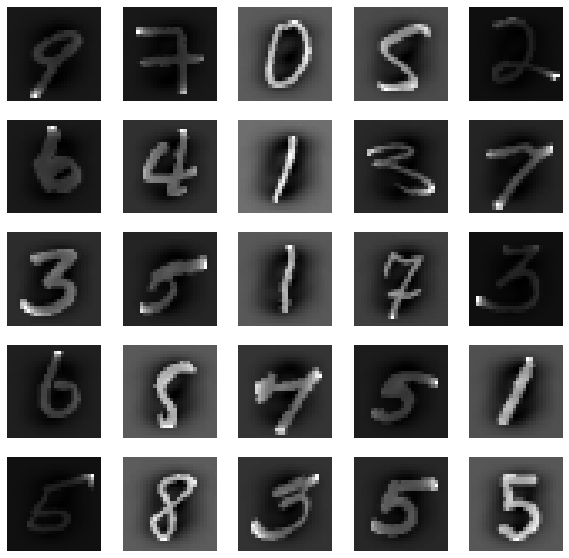

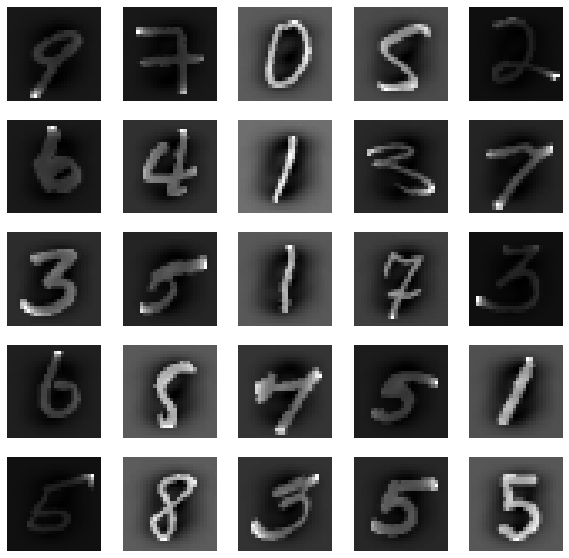

In [5]:
mnh.setup()
mnh.visualize()

Let's fit a `LogisticRegression` model and examine the templates (coefficients $\Theta$)

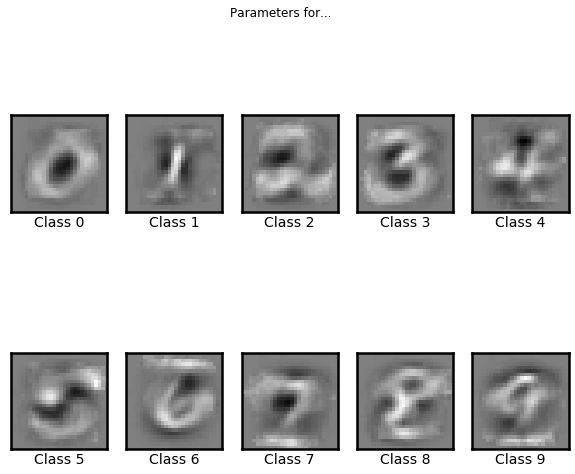

In [6]:
_= mnh.fit()
mnist_fig, mnist_ax = mnh.plot_coeff()

Recall
- There is one parameter per pixel
- The parameters are ordered in the same way as the linearization of the pixels
    - from $(28 \times 28)$ grid to a vector of 784 numbers.
- We can display the 784 parameters in a $(28 \times 28)$ image to show the intensity of parameter associated with a pixel
- White is high parameter value; Black is low (or negative)

- The template for $0$ emphasizes small values (absence of bright pixels) in the center of the image
- The template for $1$ emphasizes bright vertical pixels
- The template for $8$ emphasizes the absence of bright pixels
    - in the two circles
    - in the pinched waist

You can now imagine how these templates might lead to misclassification

What is the classification of
- a "7" with a strong vertical line in the center (that's what the "1" template tries to match)
- a thin "0" (the "0" template is looking for a large donut)

So interpretation is a very powerful diagnostic tool for both understanding and improving your models.

In [7]:
print("Done")

Done
